In [26]:
import numpy as np
import matplotlib.pyplot as plt
from jax import numpy as jnp
import jax
from tqdm import tqdm
from h5py import File
from numpyro.infer import MCMC, NUTS, init_to_median, util
import corner
from copy import copy
from getdist import plots, MCSamples
import getdist

import csiborgtools

%load_ext autoreload
%autoreload 2
%matplotlib inline

paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## LOS density & radial velocity plots 

In [14]:
# fpath = "/mnt/extraspace/rstiskalek/catalogs/A2.h5"
fpath = "/mnt/extraspace/rstiskalek/catalogs/PV_compilation_Supranta2019.hdf5"

loader_carrick = csiborgtools.flow.DataLoader("Carrick2015", "LOSS", fpath, paths, ksmooth=0)
loader_csiborg = csiborgtools.flow.DataLoader("csiborg1", "LOSS", fpath, paths, ksmooth=0)
loader_csiborg2 = csiborgtools.flow.DataLoader("csiborg2_main", "LOSS", fpath, paths, ksmooth=0)

10:20:19: reading the catalogue.
10:20:19: reading the interpolated field.


100%|██████████| 1/1 [00:00<00:00, 84.48it/s]


10:20:19: calculating the radial velocity.


100%|██████████| 50/50 [00:00<00:00, 21608.99it/s]


10:20:19: reading the catalogue.
10:20:19: reading the interpolated field.


100%|██████████| 101/101 [00:02<00:00, 42.58it/s]


10:20:21: calculating the radial velocity.


100%|██████████| 50/50 [00:00<00:00, 351.66it/s]


10:20:22: reading the catalogue.
10:20:22: reading the interpolated field.


100%|██████████| 20/20 [00:00<00:00, 123.83it/s]


10:20:22: calculating the radial velocity.


100%|██████████| 50/50 [00:00<00:00, 1285.41it/s]


In [2]:
# ks = [115,  53,  77, 105,  26,  61,  86,  29,  80,  21]
ks = [19,  8, 15,  0, 16,  6, 48, 38, 26, 44]
# ks = [19]
# ks = np.random.choice(50, 10, replace=False)

# k = 6
for k in []:
    fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
    # Get rid of vertical spacing
    fig.subplots_adjust(wspace=0)

    # Plot CSiBORG
    for i in range(loader_csiborg.los_density.shape[1]):
        axs[0].plot(loader_csiborg.rdist, loader_csiborg.los_density[k, i, :], alpha=0.1, color="black")
        axs[1].plot(loader_csiborg.rdist, loader_csiborg.los_radial_velocity[k, i, :], alpha=0.1, color="black")

    # CSiBORG1
    axs[0].plot(loader_csiborg.rdist, loader_csiborg.los_density[k, :, :].mean(axis=0), color="red", label="CSiBORG1")
    axs[1].plot(loader_csiborg.rdist, loader_csiborg.los_radial_velocity[k, :, :].mean(axis=0), color="red")

    # CSiBORG2
    axs[0].plot(loader_csiborg2.rdist, loader_csiborg2.los_density[k, :, :].mean(axis=0), color="violet", label="CSiBORG2")
    axs[1].plot(loader_csiborg2.rdist, loader_csiborg2.los_radial_velocity[k, :, :].mean(axis=0), color="violet")

    # Plot Carrick+2015
    axs[0].plot(loader_carrick.rdist, loader_carrick.los_density[k, 0, :], color="blue", label="Carrick+2015")
    axs[1].plot(loader_carrick.rdist, loader_carrick.los_radial_velocity[k, 0, :] * 0.43, color="blue")


    # for i in range(2):
    #     label = "SN"
    #     rdist = loader_csiborg.cat["r_hMpc"][k]
    #     axs[i].axvline(rdist, color="violet", linestyle="--",
    #                 zorder=0, label=label)

    axs[1].set_xlabel(r"$r ~ [\mathrm{Mpc} / h]$")
    axs[0].set_ylabel(r"$\rho_{\rm LOS} / \langle \rho_{\rm matter} \rangle$")
    axs[1].set_ylabel(r"$v_{\rm LOS} ~ [\mathrm{km/s}]$")

    axs[0].set_yscale("log")

    axs[0].legend(loc="upper right")
    axs[0].set_xlim(0, 200)

    fig.tight_layout(w_pad=0, h_pad=0)
    fig.savefig(f"../plots/LOSS_los_{k}.png", dpi=500, bbox_inches="tight")

    fig.show()

## Test running a model

In [396]:
fpath_data = "/mnt/extraspace/rstiskalek/catalogs/PV_compilation_Supranta2019.hdf5"
# fpath_data = "/mnt/extraspace/rstiskalek/catalogs/A2.h5"

simname = "Carrick2015"
catalogue = "LOSS"
loader = csiborgtools.flow.DataLoader(simname, 0, catalogue, fpath_data, paths, ksmooth=0)
get_model_kwargs = {"zcmb_max": 0.06}

17:23:04: reading the catalogue.
17:23:04: reading the interpolated field.
17:23:04: calculating the radial velocity.


In [397]:
loader.los_density.shape

(50, 399)

### Maximizing the log-likelihood

In [398]:
# k = 0
# samples, stats, fmin, logz, bic = csiborgtools.flow.optimize_model_with_jackknife(loader, k, 10, True, get_model_kwargs=get_model_kwargs)

# print("Log Z: ")
# print(np.mean(logz), np.std(logz))

# print("BIC: ")
# print(np.mean(bic), np.std(bic))

# print("beta: ")
# print(*stats["beta"])
# print(samples["beta"])

#### Running HMC

In [399]:
model = csiborgtools.flow.get_model(loader, **get_model_kwargs)

Selected 50/50 galaxies.


In [400]:
kernel = NUTS(model, init_strategy=init_to_median(num_samples=100))
mcmc = MCMC(kernel, num_warmup=250, num_samples=2500)

rng_key = jax.random.PRNGKey(5)

In [401]:
model_kwargs = {"sample_alpha": True}
mcmc.run(rng_key, **model_kwargs)

sample: 100%|██████████| 2750/2750 [00:32<00:00, 84.40it/s, 7 steps of size 4.13e-01. acc. prob=0.91]  


In [402]:
csiborgtools.numpyro_gof(model, mcmc, len(loader.cat), model_kwargs)

{'BIC': 773.5717163085938,
 'AIC': 754.4514770507812,
 'logZ': -356.15753173828125}

In [404]:
mcmc.print_summary()
samples = mcmc.get_samples(group_by_chain=False)


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
          Vext_x    -16.69     75.95    -15.21   -132.91    118.30   1460.49      1.00
          Vext_y    -24.01    105.18    -28.09   -188.07    154.02   1522.27      1.00
          Vext_z    -88.49    152.80    -89.86   -341.05    169.93   1303.93      1.00
           alpha      1.01      0.39      0.95      0.40      1.61   2728.86      1.00
       alpha_cal      0.13      0.02      0.13      0.09      0.17   2106.27      1.00
            beta      0.44      0.11      0.45      0.28      0.62   2280.95      1.00
        beta_cal      3.53      0.19      3.53      3.21      3.83   1598.26      1.00
  e_mu_intrinsic      0.09      0.03      0.08      0.04      0.12   1790.78      1.00
         mag_cal    -18.19      0.04    -18.20    -18.26    -18.13   1351.76      1.00
         sigma_v    181.29     55.02    175.90     93.08    265.91   1889.45      1.00

Number of divergences: 0


In [348]:
Vmag = np.sqrt(samples["Vext_x"]**2 + samples["Vext_y"]**2 + samples["Vext_z"]**2)

V = np.vstack([samples["Vext_x"], samples["Vext_y"], samples["Vext_z"]]).T
V = csiborgtools.cartesian_to_radec(V)

l, b = csiborgtools.flow.radec_to_galactic(V[:, 1], V[:, 2])

print(f"|V|  = {np.mean(Vmag)} +- {np.std(Vmag)}")
print(f"l    = {np.mean(l)} +- {np.std(l)}")
print(f"b    = {np.mean(b)} +- {np.std(b)}")
print(f"beta = {np.mean(samples['beta'])} +- {np.std(samples['beta'])}")

In [352]:
if "alpha" in samples:
    data = np.vstack([samples["alpha"], samples["beta"], l, b, Vmag]).T
    labels = [r"$\alpha$", r"$\beta$", r"$l$", r"$b$", r"$|\bf{V}_{\rm ext}|$"]
else:
    data = np.vstack([samples["beta"], l, b, Vmag]).T
    labels = [r"$\beta$", r"$l$", r"$b$", r"$|\bf{V}_{\rm ext}|$"]

fig = corner.corner(data, labels=labels, show_titles=True, title_fmt=".3f", title_kwargs={"fontsize": 12}, smooth=1)

## Vizualize the results

####  Functions to read in the results

In [95]:
def read_samples(catalogue, simname, ksmooth, include_calibration=False):
    paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)
    nsims = paths.get_ics(simname)

    Vx, Vy, Vz, beta, sigma_v, alpha = [], [], [], [], [], []
    BIC, AIC, logZ = [], [], []

    if catalogue in ["LOSS", "Foundation", "Pantheon+"]:
        alpha_cal, beta_cal, mag_cal, e_mu_intrinsic = [], [], [], []
    else:
        raise ValueError(f"Catalogue {catalogue} not recognized.")

    fname = f"/mnt/extraspace/rstiskalek/csiborg_postprocessing/peculiar_velocity/flow_samples_{catalogue}_{simname}_smooth_{ksmooth}.hdf5"
    with File(fname, 'r') as f:
        for __, nsim in enumerate(tqdm(nsims)):
            Vx.append(f[f"sim_{nsim}/Vext_x"][:])
            Vy.append(f[f"sim_{nsim}/Vext_y"][:])
            Vz.append(f[f"sim_{nsim}/Vext_z"][:])
            alpha.append(f[f"sim_{nsim}/alpha"][:])
            beta.append(f[f"sim_{nsim}/beta"][:])
            sigma_v.append(f[f"sim_{nsim}/sigma_v"][:])

            BIC.append(f[f"sim_{nsim}/BIC"][...])
            AIC.append(f[f"sim_{nsim}/AIC"][...])
            logZ.append(f[f"sim_{nsim}/logZ"][...])

            if catalogue in ["LOSS", "Foundation", "Pantheon+"]:
                alpha_cal.append(f[f"sim_{nsim}/alpha_cal"][:])
                beta_cal.append(f[f"sim_{nsim}/beta_cal"][:])
                mag_cal.append(f[f"sim_{nsim}/mag_cal"][:])
                e_mu_intrinsic.append(f[f"sim_{nsim}/e_mu_intrinsic"][:])
            else:
                raise ValueError(f"Catalogue {catalogue} not recognized.")

    Vx, Vy, Vz, alpha, beta, sigma_v = np.hstack(Vx), np.hstack(Vy), np.hstack(Vz), np.hstack(alpha), np.hstack(beta), np.hstack(sigma_v)  # noqa

    gof = np.hstack(BIC), np.hstack(AIC), np.hstack(logZ)

    if catalogue in ["LOSS", "Foundation", "Pantheon+"]:
        alpha_cal, beta_cal, mag_cal, e_mu_intrinsic = np.hstack(alpha_cal), np.hstack(beta_cal), np.hstack(mag_cal), np.hstack(e_mu_intrinsic)  # noqa
    else:
        raise ValueError(f"Catalogue {catalogue} not recognized.")

    # Calculate magnitude of V_ext
    Vmag = np.sqrt(Vx**2 + Vy**2 + Vz**2)
    # Calculate direction in galactic coordinates of V_ext
    V = np.vstack([Vx, Vy, Vz]).T
    V = csiborgtools.cartesian_to_radec(V)
    l, b = csiborgtools.flow.radec_to_galactic(V[:, 1], V[:, 2])

    if catalogue in ["LOSS", "Foundation", "Pantheon+"]:
        data = [alpha, beta, Vmag, l, b, sigma_v]
        names = ["alpha", "beta", "Vmag", "l", "b", "sigma_v"]

        if include_calibration:
            data += [alpha_cal, beta_cal, mag_cal, e_mu_intrinsic]
            names += ["alpha_cal", "beta_cal", "mag_cal", "e_mu_intrinsic"]
    else:
        raise ValueError(f"Catalogue {catalogue} not recognized.")

    return np.vstack(data).T, names, gof


def names_to_latex(names, for_corner=False):
    ltx = {"alpha": "\\alpha",
           "beta": "\\beta",
           "Vmag": "V_{\\rm ext} ~ [\\mathrm{km} / \\mathrm{s}]",
           "sigma_v": "\\sigma_v ~ [\\mathrm{km} / \\mathrm{s}]",
           }

    ltx_corner = {"alpha": r"$\alpha$",
                  "beta": r"$\beta$",
                  "Vmag": r"$V_{\rm ext}$",
                  "sigma_v": r"$\sigma_v$",
                  }

    labels = copy(names)
    for i, label in enumerate(names):
        if label in ltx:
            labels[i] = ltx_corner[label] if for_corner else ltx[label]

    return labels

### Quickview

100%|██████████| 1/1 [00:00<00:00, 69.24it/s]

BIC  = 773.225037 +- 0.000000
AIC  = 754.104797 +- 0.000000
logZ = -356.240234 +- 0.000000


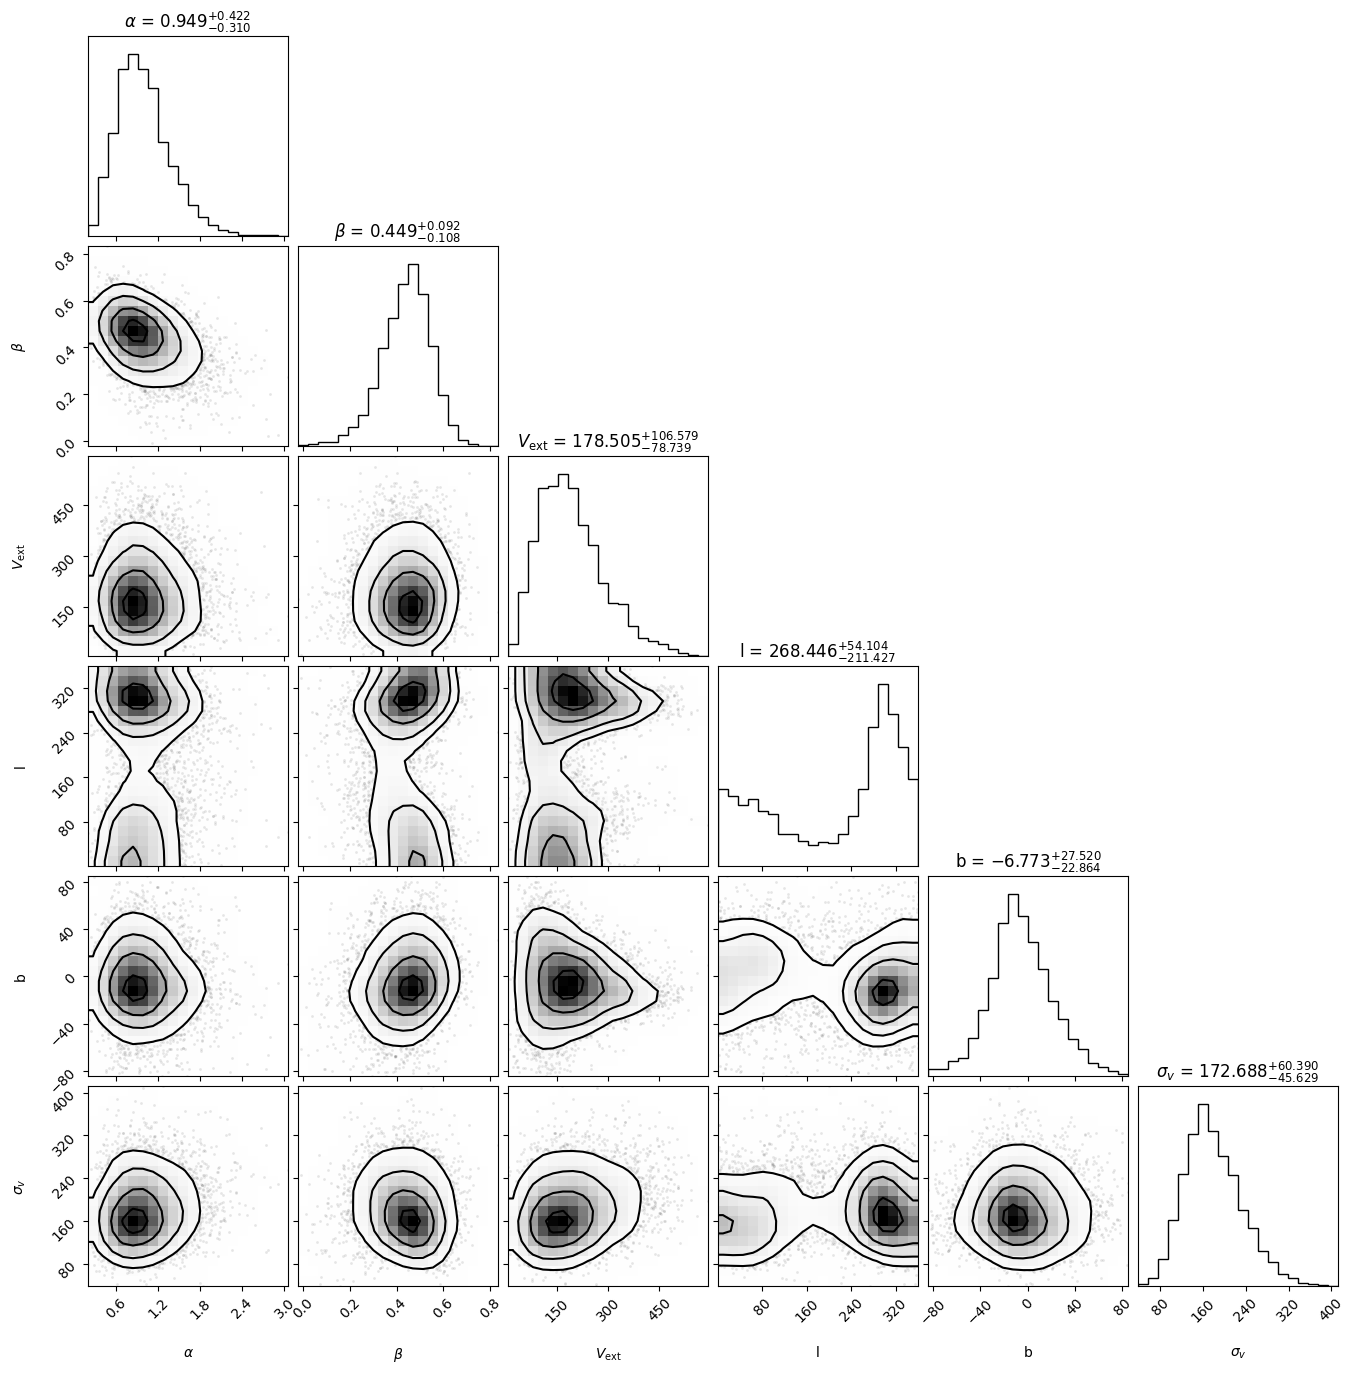

In [96]:
data, names, gof = read_samples("LOSS", "Carrick2015", 0)
print("BIC  = {:4f} +- {:4f}".format(np.mean(gof[0]), np.std(gof[0])))
print("AIC  = {:4f} +- {:4f}".format(np.mean(gof[1]), np.std(gof[1])))
print("logZ = {:4f} +- {:4f}".format(np.mean(gof[2]), np.std(gof[2])))

fig = corner.corner(data, labels=names_to_latex(names, True), show_titles=True,
                    title_fmt=".3f", title_kwargs={"fontsize": 12}, smooth=1)

### LOSS-only comparison

In [100]:
data, names, gof = read_samples("LOSS", "Carrick2015", 0)
print("Carrick+2015, kappa = 0")
print("BIC = {:.4f}".format(np.mean(gof[0])))
print("AIC = {:.4f}".format(np.mean(gof[1])))
print("logZ = {:.4f}".format(np.mean(gof[2])))
print()
LOSS_Carrick_0 = MCSamples(samples=data, names=names, labels=names_to_latex(names),
                           label=r"Carrick+2015, LOSS")

data, names, gof = read_samples("LOSS", "Carrick2015", 1)
print("Carrick+2015, kappa = 2")
print("BIC = {:.4f}".format(np.mean(gof[0])))
print("AIC = {:.4f}".format(np.mean(gof[1])))
print("logZ = {:.4f}".format(np.mean(gof[2])))
print()
LOSS_Carrick_1 = MCSamples(samples=data, names=names, labels=names_to_latex(names),
                           label=r"Carrick+2015, LOSS, $\kappa = 2$")

data, names, gof = read_samples("LOSS", "csiborg2_main", 0)
print("CSiBORG2, kappa = 0")
print("BIC = {:.4f}".format(np.mean(gof[0])))
print("AIC = {:.4f}".format(np.mean(gof[1])))
print("logZ = {:.4f}".format(np.mean(gof[2])))
print()
LOSS_CB2_0 = MCSamples(samples=data, names=names, labels=names_to_latex(names),
                       label=r"CSiBORG2, LOSS")

data, names, gof = read_samples("LOSS", "csiborg2_main", 1)
print("CSiBORG2, kappa = 2")
print("BIC = {:.4f}".format(np.mean(gof[0])))
print("AIC = {:.4f}".format(np.mean(gof[1])))
print("logZ = {:.4f}".format(np.mean(gof[2])))
print()
LOSS_CB2_1 = MCSamples(samples=data, names=names, labels=names_to_latex(names),
                       label=r"CSiBORG2, LOSS, $\kappa = 2$")

100%|██████████| 1/1 [00:00<00:00, 35.06it/s]


Carrick+2015, kappa = 0
BIC = 773.2250
AIC = 754.1048
logZ = -356.2402

Removed no burn in


100%|██████████| 1/1 [00:00<00:00, 51.21it/s]


Carrick+2015, kappa = 2
BIC = 775.7410
AIC = 756.6208
logZ = -357.0956

Removed no burn in


100%|██████████| 20/20 [00:00<00:00, 33.82it/s]


CSiBORG2, kappa = 0
BIC = 758.6469
AIC = 739.5267
logZ = -350.5136

Removed no burn in


100%|██████████| 20/20 [00:00<00:00, 48.70it/s]


CSiBORG2, kappa = 0
BIC = 759.3940
AIC = 740.2737
logZ = -349.6684

Removed no burn in


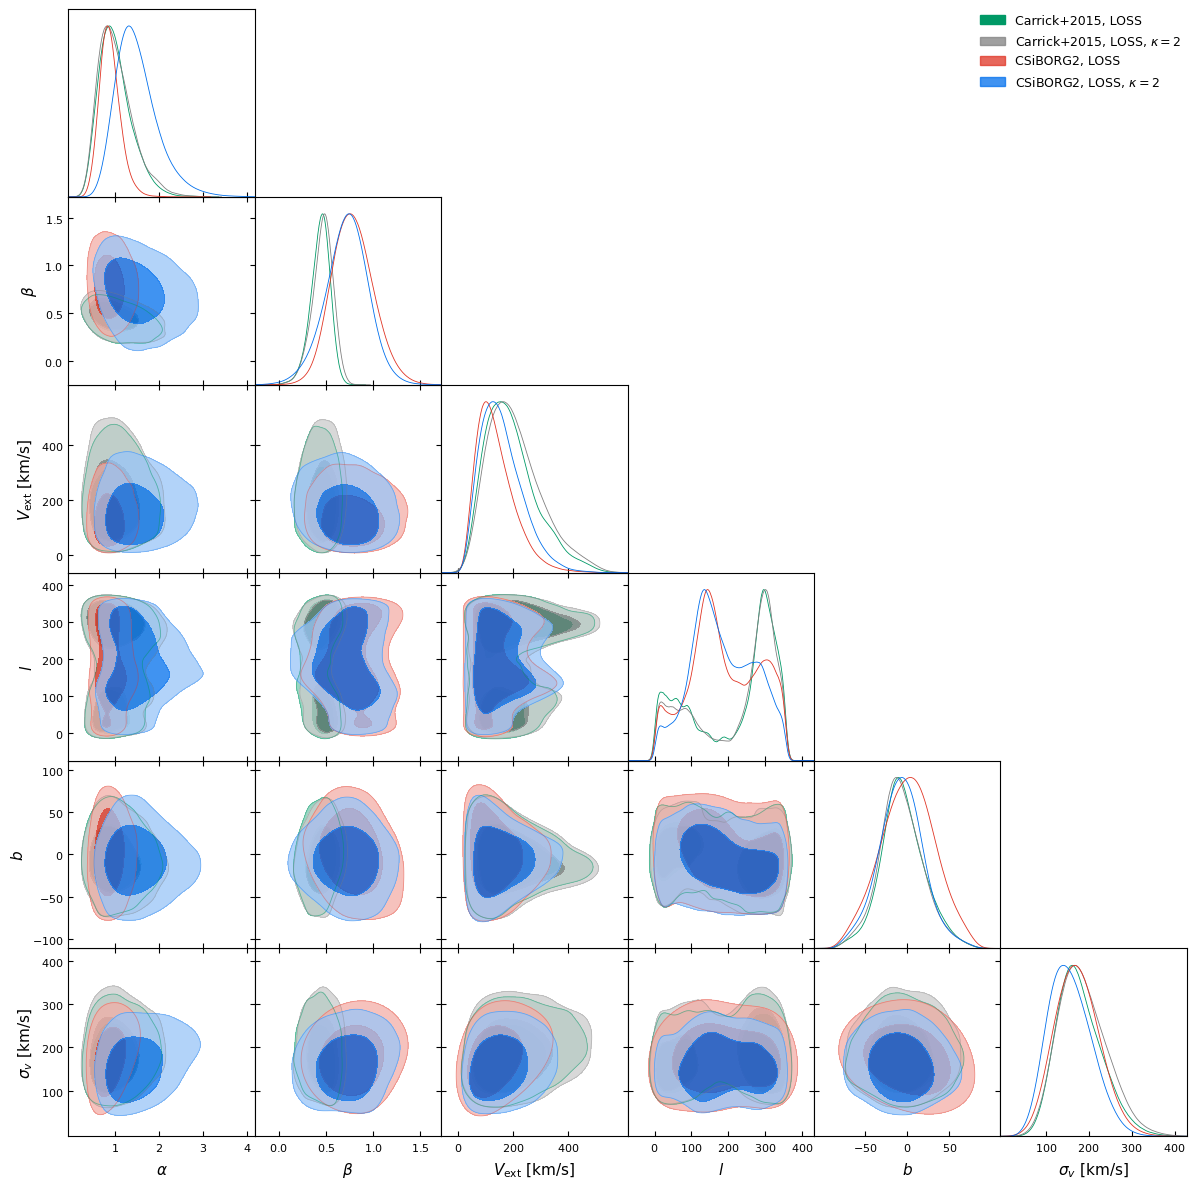

In [104]:
X = [LOSS_Carrick_0,
     LOSS_Carrick_1,
     LOSS_CB2_0,
     LOSS_CB2_1,
     ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
g.export(f"../plots/LOSS_comparison.png", dpi=500,)


### Foundation-only comparison

In [98]:
data, names, gof = read_samples("Foundation", "Carrick2015", 0)
print("Carrick+2015, kappa = 0")
print("BIC = {:.4f}".format(np.mean(gof[0])))
print("AIC = {:.4f}".format(np.mean(gof[1])))
print("logZ = {:.4f}".format(np.mean(gof[2])))
print()
FOUNDATION_Carrick_0 = MCSamples(samples=data, names=names, labels=names_to_latex(names),
                                 label=r"Carrick+2015, Foundation")

data, names, gof = read_samples("Foundation", "Carrick2015", 1)
print("Carrick+2015, kappa = 2")
print("BIC = {:.4f}".format(np.mean(gof[0])))
print("AIC = {:.4f}".format(np.mean(gof[1])))
print("logZ = {:.4f}".format(np.mean(gof[2])))
print()
FOUNDATION_Carrick_1 = MCSamples(samples=data, names=names, labels=names_to_latex(names),
                                 label=r"Carrick+2015, Foundation, $\kappa = 2$")


100%|██████████| 1/1 [00:00<00:00, 41.87it/s]


Carrick+2015, kappa = 0
BIC = 1852.8672
AIC = 1824.6644
logZ = -897.5375

Removed no burn in


100%|██████████| 1/1 [00:00<00:00, 104.30it/s]

Carrick+2015, kappa = 2
BIC = 1855.8043
AIC = 1827.6016
logZ = -899.1472

Removed no burn in


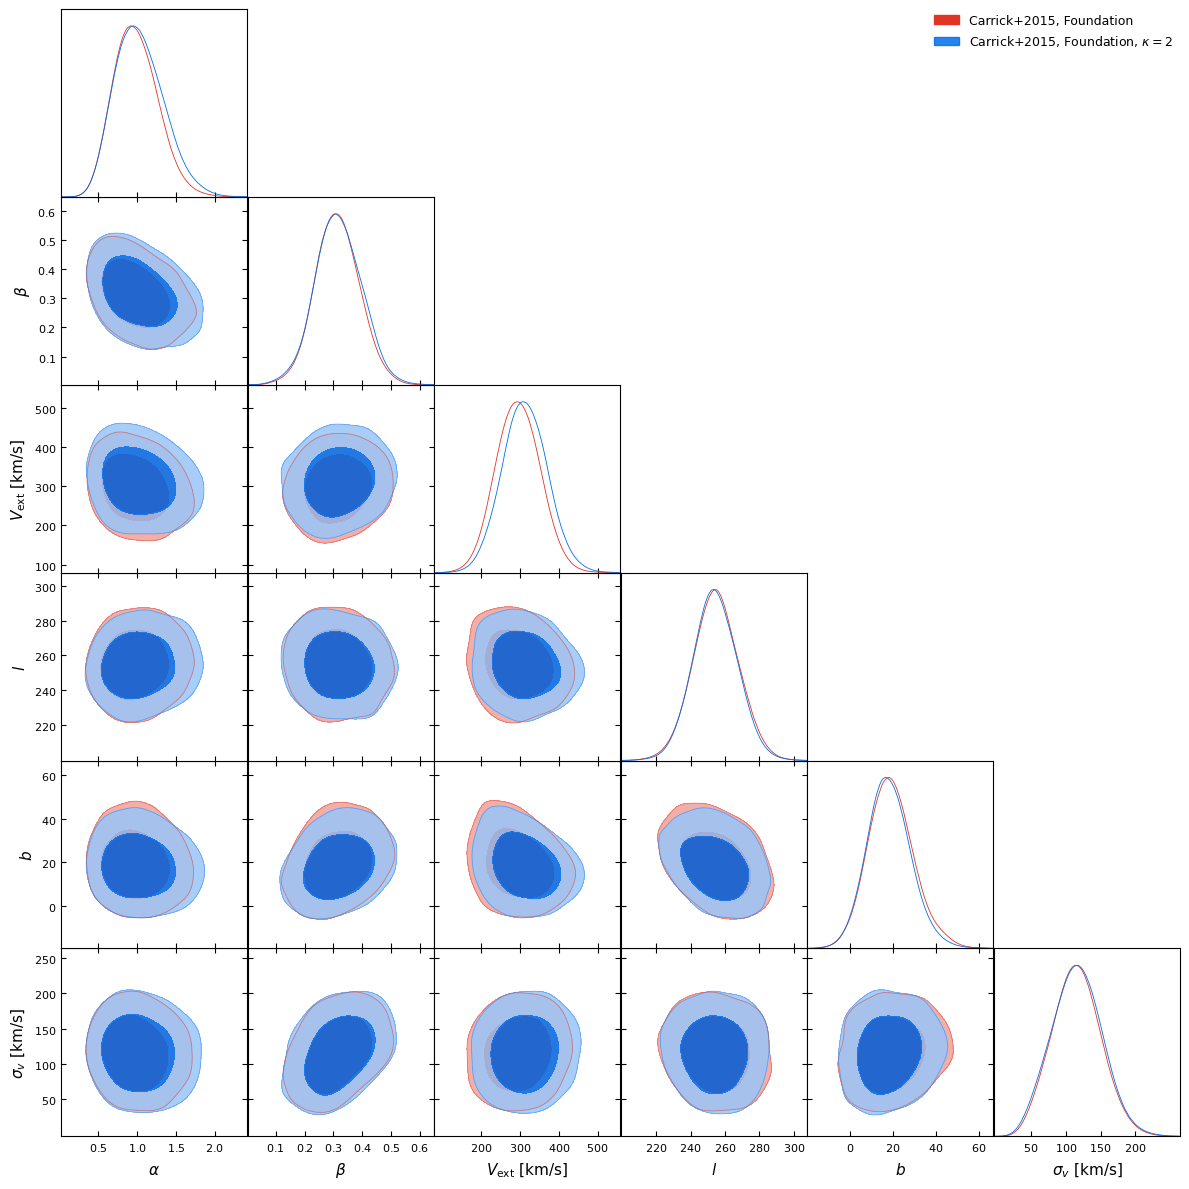

In [99]:
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
# g.settings.title_limit_fontsize = 14
g.triangle_plot([FOUNDATION_Carrick_0, FOUNDATION_Carrick_1], filled=True,
                legend_loc='upper right')

## Test bias